In [1]:
from landaunet import geom, _core

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [3]:
dom = geom.Periodic2D(64,64,0.1,1)

In [4]:

class UnitNormVec3RF:
    def __init__(self,  N=12, mostly_z = None):

        self.N = N

        self.freqs = 2*np.pi*np.arange(-N*1.0, N+1.0, 1.0)
        self.fsize = 2*N+1
        self.mostly_z = mostly_z

    def random(self, size):
        magnitudes = (np.random.randn(size, 3 * (self.fsize)**2) +
                      1j*np.random.randn(size, 3 * (self.fsize)**2)) \
                      * 1/(2*self.fsize)**2

        return magnitudes

    def eval_batch(self, features, xs):
        x_tr = np.exp(1j*np.outer(xs[:,0], self.freqs))
        y_tr = np.exp(1j*np.outer(xs[:,1], self.freqs))

        f = np.reshape(features, (-1, self.freqs.size, self.freqs.size, 3))
        prod = np.einsum('abcd, qb, qc -> aqd', f, x_tr, y_tr).real
        prod = np.array(prod/np.linalg.norm(prod, axis=-1)[..., None])
        if self.mostly_z is not None:
            prod = prod * (1-self.mostly_z)
            prod[:,:,-1] += 1
            prod = np.array(prod/np.linalg.norm(prod, axis=-1)[..., None])

        return prod

In [5]:
space = UnitNormVec3RF(N=2, mostly_z=0.9)

In [6]:
r = space.random(1)
n=50

x = np.arange(0,1,1/n)
X, Y = np.meshgrid(x,x)
pts = np.hstack([X.flatten()[:,None],Y.flatten()[:,None]])


In [7]:
fn = space.eval_batch(r,pts).reshape((n,n,3))
fn = np.moveaxis(fn,2,0).copy()

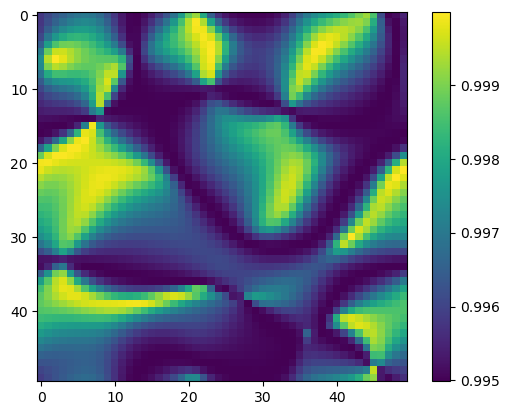

In [8]:
plt.imshow(fn[2])
plt.colorbar()
plt.show()

In [9]:
dom = geom.Periodic2D(n,n,0.02,1,data=fn)
dt = 0.1

In [10]:
P, Qhalf = geom.red_black_isotropic_start(fn, dt)
Q = Qhalf

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 50 is different from 3)

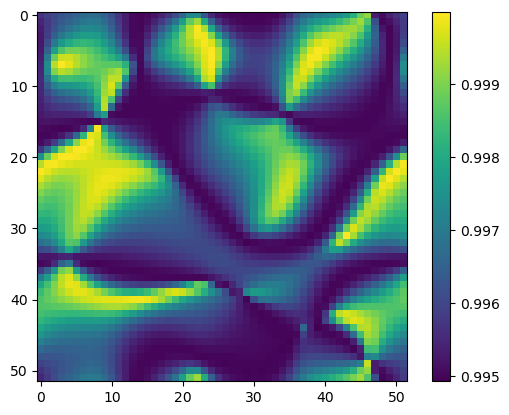

In [13]:
pd = geom.Periodic2D(n,n,0.1,1,data=fn)
pd.setup_data()
plt.imshow(pd.data[2])
plt.colorbar()
plt.show()

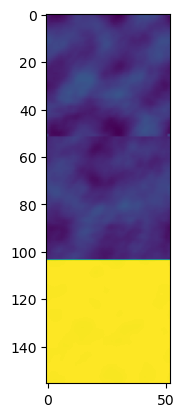

In [14]:
ims = []
fig, ax = plt.subplots()
for k in range(1000):
    pd.step()
    if k % 10 == 0:
        im = ax.imshow(np.reshape(pd.data,(3*(n+2),(n+2))), animated=True)
        ims.append([im])


In [15]:
ani = animation.ArtistAnimation(fig, ims, interval=30, blit=True,
                                repeat_delay=1000)
from IPython.display import HTML
HTML(ani.to_html5_video())